In [1]:
import os
import json
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams["font.family"] = "Times New Roman"

''' Install fonts on Ubuntu:
sudo apt install msttcorefonts -qq
rm ~/.cache/matplotlib -rf           # remove cache
'''

' Install fonts on Ubuntu:\nsudo apt install msttcorefonts -qq\nrm ~/.cache/matplotlib -rf           # remove cache\n'

In [2]:
def plot_metric(metric_data, metric_std_data, xlabel, ylabel,
                methods, xrange, colors, labels, fname=None):
    """
    Generates and displays a plot for a given metric with shaded standard deviation.

    Args:
        metric_data (dict): A dictionary where keys are method names and values
                            are lists/arrays of metric values over iterations.
        metric_std_data (dict): A dictionary where keys are method names and values
                                are lists/arrays of standard deviation values for the metric.
        xlabel (str): The label for the x-axis of the plot.
        ylabel (str): The label for the y-axis of the plot.
        methods (list): A list of method names (keys in metric_data).
        xrange (list or np.array): The range of x-axis values.
        colors (list): A list of colors for each method's plot.
        labels (list): A list of labels for each method's legend entry.
        fname (str): The filename for saving the plot.
    """
    plt.figure()
    for i, key in enumerate(methods):
        xrange_ = xrange[:len(metric_data[key])]
        label = labels[i]

        plt.plot(xrange_, metric_data[key], label=label, c=colors[i])
        plt.fill_between(xrange_,
                         np.array(metric_data[key]) + np.array(metric_std_data[key]),
                         np.array(metric_data[key]) - np.array(metric_std_data[key]),
                         alpha=0.2,
                         color=colors[i])
    
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if fname is not None:
        plt.savefig(f'{fname}', bbox_inches='tight', dpi=500)
    plt.show()

Loading results from nantucket_1R_2S_B.json


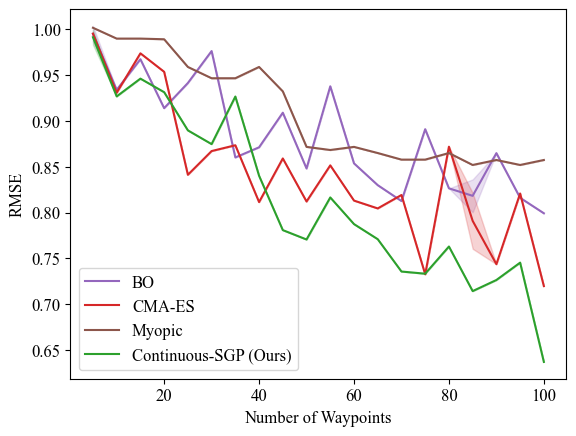

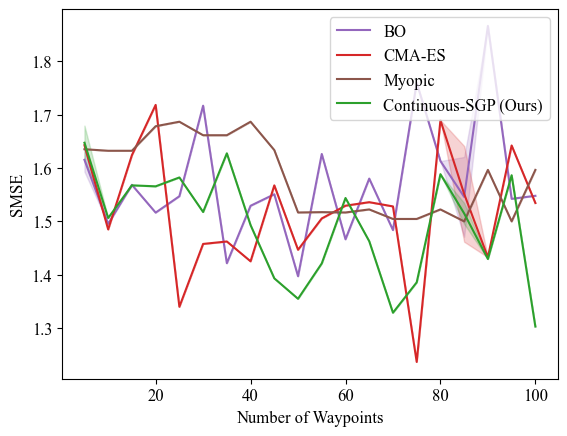

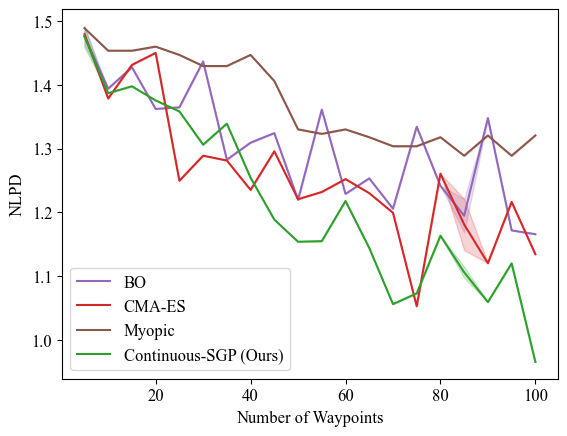

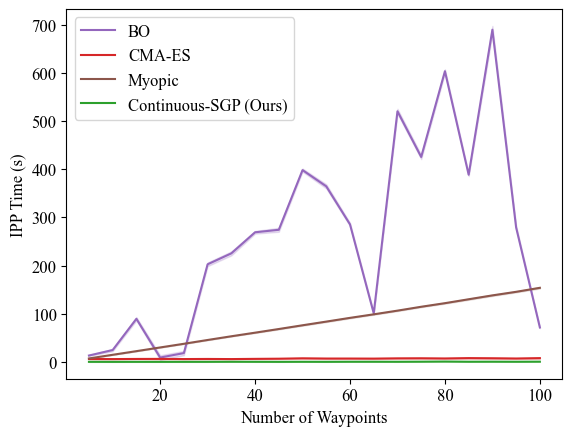

In [3]:
num_robots = 1
sampling_rate = 2
dataset = 1 # Options: 0: mississippi, 1: nantucket, 2: virgin_islands, 3: wrangell
budget = True
benchmark = 1 # Options: 0: Adaptive, 1: Non-Adaptive

dataset_names = ['mississippi',
                 'nantucket',
                 'virgin_islands',
                 'wrangell']
dataset = dataset_names[dataset]

# Adaptive Methods
if benchmark==0:
    colors = ['C2', 'C3', 'C0', 'C1']
    methods = ['Adaptive-SGP', 
               'Adaptive-CMA-ES', 
               'SGP', 
               'CMA-ES']
# Non-Adaptive Methods
elif benchmark==1:
    methods = ['CMA-ES', 
               'SGP']
    labels = ['CMA-ES',
              'Continuous-SGP (Ours)']
    colors = ['C3', 'C2']

    if sampling_rate == 2 and \
       num_robots == 1 and \
       budget:
        methods = ['BO', 
                   'CMA-ES', 
                   'Myopic',
                   'SGP']
        labels = ['BO',
                  'CMA-ES',
                  'Myopic',
                  'Continuous-SGP (Ours)']
        colors = ['C4', 'C3', 'C5', 'C2']
    if sampling_rate == 2 and \
       num_robots == 1 and \
       not budget:
        methods = ['BO', 
                   'CMA-ES',
                   'Myopic',
                   'Greedy-MI',
                   'Greedy-SGP',
                   'Discrete-SGP',
                   'SGP']
        labels = ['BO',
                  'CMA-ES',
                  'Myopic',
                  'Greedy-MI',
                  'Greedy-SGP (Ours)',
                  'Discrete-SGP (Ours)',
                  'Continuous-SGP (Ours)']
        colors = ['C4', 'C3', 'C5', 'C1', 'C6', 'C0', 'C2']

if budget:
    flag = '_B'
else:
    flag = ''

rmse = defaultdict(list)
rmse_std = defaultdict(list)

smse = defaultdict(list)
smse_std = defaultdict(list)

nlpd = defaultdict(list)
nlpd_std = defaultdict(list)

param_time = defaultdict(list)
param_time_std = defaultdict(list)

ipp_time = defaultdict(list)
ipp_time_std = defaultdict(list)

filename = f'{dataset}_{num_robots}R_{sampling_rate}S{flag}.json'
print(f'Loading results from {filename}')
save_filename = filename[:-5] + '-{}.pdf'
save_filename = os.path.join('plots', save_filename)
if not os.path.exists('plots'):
    os.makedirs('plots')
results = json.load(open(filename, 'r'))

xrange = np.array(list(results.keys())).astype(int)
for num_sensors in results.keys():
    for method in  results[num_sensors].keys():
        for metric in results[num_sensors][method].keys():
            if metric=='RMSE':
                rmse[method].append(np.mean(results[num_sensors][method][metric]))
                rmse_std[method].append(np.std(results[num_sensors][method][metric]))
            elif metric=='SMSE':
                smse[method].append(np.mean(results[num_sensors][method][metric]))
                smse_std[method].append(np.std(results[num_sensors][method][metric]))
            elif metric=='NLPD':
                nlpd[method].append(np.mean(results[num_sensors][method][metric]))
                nlpd_std[method].append(np.std(results[num_sensors][method][metric]))
            elif metric=='ParamTime':
                data = np.array(results[num_sensors][method][metric])
                if 'Adaptive' in method:
                    data /= int(num_sensors)
                param_time[method].append(np.mean(data))
                param_time_std[method].append(np.std(data))
            elif metric=='IPPTime':
                data = np.array(results[num_sensors][method][metric])
                if 'Adaptive' in method:
                    data /= int(num_sensors)
                ipp_time[method].append(np.mean(data))
                ipp_time_std[method].append(np.std(data))

# Plot RMSE
plot_metric(rmse, rmse_std, "Number of Waypoints", "RMSE",
            methods, xrange, colors, labels, save_filename.format('rmse'))

# Plot SMSE
plot_metric(smse, smse_std, "Number of Waypoints", "SMSE",
            methods, xrange, colors, labels, save_filename.format('smse'))

# Plot NLPD
plot_metric(nlpd, nlpd_std, "Number of Waypoints", "NLPD",
            methods, xrange, colors, labels, save_filename.format('nlpd'))

# Plot IPP Time
plot_metric(ipp_time, ipp_time_std, "Number of Waypoints", "IPP Time (s)",
            methods, xrange, colors, labels, save_filename.format('ipp_time'))

In [4]:
# Times speedup
np.array(ipp_time['CMA-ES']).mean()/np.array(ipp_time['SGP']).mean()

11.313379943928558